# Events

Events are sudden changes to counts in the simulation happening at specific times or due to the fulfillment of certain conditions. 
For the first example, we focus only on the specific time by setting the count of a meta-species to 200 every 5 seconds. 
The event notation for time-based events lies in putting the simulation object under context with Python's native "with" notation and then using the event\_time method. 
When the simulation is under context with Python's "with," every count assignment performed will not be an initial condition but an event. 

Compiling model



Species
A,200

Mappings
A :
A

Parameters
volume,1

Reactions
reaction_0,{'re': [(1, 'A')], 'pr': [], 'kin': 'A * 1'}

Events
event_0,{'trigger': 'true', 'delay': '10', 'assignments': [('A', '200')]}
event_1,{'trigger': 'true', 'delay': '5', 'assignments': [('A', '200')]}



Starting Simulator
Running simulation in parallel
Simulation is Over


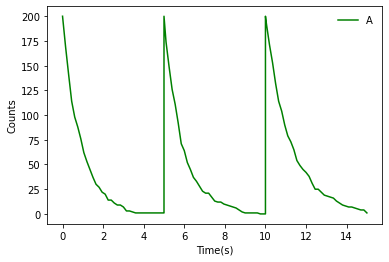

In [1]:
from mobspy import *

A = BaseSpecies()

A >> Zero [1]

A(200)
S = Simulation(A)
S.method = 'stochastic'
S.duration = 15
S.output_event = True

with S.event_time(5):
    A(200)

with S.event_time(10):
    set_counts({A: 200})

print(S.compile())
S.run()

The other type of event is condition-based. Condition-based events trigger when the total amount of a meta-species reaches a specific value. 
The notation is similar to the time event by putting a simulation under context. However, the method used is called event_condition. This method also receives as an argument a logic expression constructed by using meta-species. 

Compiling model



Species
A.a1,100
A.a2,100
B.b1,120
B.b2,120

Mappings
A :
A.a1
A.a2
B :
B.b1
B.b2

Parameters
volume,1

Reactions
reaction_0,{'re': [(1, 'A.a1'), (1, 'B.b1')], 'pr': [], 'kin': 'A.a1 * B.b1 * 0.01 * volume^-1'}
reaction_1,{'re': [(1, 'A.a2'), (1, 'B.b2')], 'pr': [], 'kin': 'A.a2 * B.b2 * 0.02 * volume^-1'}

Events
event_0,{'trigger': '( ( (A.a1 + A.a2) <= 50 ) && ( (B.b1 + B.b2) <= 50 ) ) ', 'delay': '0', 'assignments': [('A.a1', '100'), ('A.a2', '100'), ('B.b1', '120'), ('B.b2', '120')]}



Starting Simulator
Simulation is Over


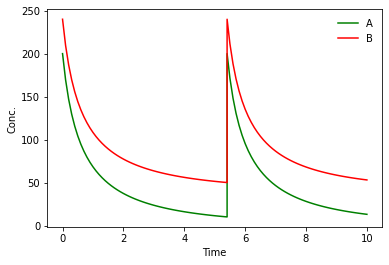

In [2]:
from mobspy import *

A, B = BaseSpecies()

A.a1, A.a2, B.b1, B.b2

A.a1 + B.b1 >> Zero [0.01]
A.a2 + B.b2 >> Zero [0.02]

All[A](100), All[B](120)
S = Simulation(A | B)
S.duration = 10
S.output_event = True

logic_expression = (A <= 50) & (B <= 50)
with S.event_condition(logic_expression):
    All[A](100), All[B](120)

print(S.compile())
S.run()

In logic expressions, MobsPy automatically maps all states of a meta-species through a sum to evaluate their total amount (in the example, A = A.a1 + A.a2 and B = B.b1 + B.b2). If the sum of the counts of the species states satisfies the logic condition, it will trigger. The logic expressions are also compatible with the dot notation query to specify only a sum of substates of a meta-species.

Unfortunately, logical clauses in MobsPy must be isolated in parenthesis when combined to respect Python operator precedence. As if the parenthesis were not there, Python would try to resolve the and operator '&' before the inequalities. 

The accepted operators and operations are the following: sum of different meta-species, multiplication by constant, greater and equal (>=), smaller and equal (<=), greater (>), smaller (<), and ('&'), and or ('|'). Notice that equality is not accepted as it is not an overridable operator in Python. In that case, the user must use the combination of greater and equal (>=), smaller and equal (<=), and the and ('&'). 

In [3]:
# Perform a query 
c1 = A.a1 <= 10 
# Combine clauses
c2 = ((A.a1 <= 10) | (B >= 5)) & (A.a2 >= 5)

# EQUALITY IS NOT ALLOWED AND WILL PRODUCE ERRORS 
# The alternative is them 
c3 = (A <= 5) & (A >= 5)

Logical expressions can also create simulations with a conditional duration by setting the duration equal to one. 
For instance, the simulation below runs until either A or B reaches zero.

In [4]:
from mobspy import *

A, B = BaseSpecies()

A + B >> Zero [0.01]

A(110), B(100)
S = Simulation(A | B)
S.method = 'stochastic'
S.duration = (A <= 0) | (B <= 0)
S.run()

Compiling model
Starting Simulator
Simulation is Over
ERROR: At:             copier = getattr(x, "__deepcopy__", None) 
Line number: 151 
Characteristic name __deepcopy__ in object A is not allowed. Please pick another name


SystemExit: 1

/Users/fabriciocravo/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3445: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


As an important note, reactions CANNOT be added as events.